# Программирование для всех (основы работы с Python)

*Алла Тамбовцева, НИУ ВШЭ*

## Практикум 3.2: предварительная обработка текста и построение облака слов

### Подготовка к работе

В этом практикуме мы будем работать с текстом, в частности, построим на основе текста облако слов (*word cloud*), которое показывает, какие слова встречаются в тексте чаще, а какие – реже.

Установим необходимые библиотеки:

* библиотека `wordcloud` для построения облака слов ([тьюториал](https://www.datacamp.com/tutorial/wordcloud-python) по работе с библиотекой);
* библиотека `pymorphy3` для морфологического анализа текстов, понадобится для приведения слов к начальной форме ([документация](https://pymorphy2.readthedocs.io/en/stable/)).

In [ ]:
!pip install --upgrade pip
!pip install --upgrade wordcloud 
!pip install --upgrade pymorphy3

Команда `pip install ...` используется для установки библиотек, к ней можно добавить опцию `--upgrade` на случай, если библиотека на компьютере уже установлена в более старой версии, а мы хотим её обновить. Символ `!` в начале строки сообщает Jupyter, что это особая операция, как будто бы запускаемая с командной строки или из терминала, а не код Python с соответствующим синтаксисом. Строка с установкой `pip` в самом начале нужна для обновления самого установщика `pip` (если версия установщика старая, логично, что он не все новые версии библиотек сможет корректно поставить).

Импортируем библиотеки, чтобы убедиться, что всё установилось (для надёжности можно перезапустить ядро через *Kernel - Restart* и после импортировать):

In [1]:
import wordcloud
import pymorphy3

Также импортируем модуль `pyplot` с сокращённым названием `plt` из библиотеки `matplotlib` для отрисовки графиков:

In [2]:
from matplotlib import pyplot as plt

Глобальная задача практикума – построить облако слов для текстов песен Владимира Высоцкого, сохраненных в txt-файле, и сделать его в форме гитары.

Наши первые шаги:

1. Скачать файл `songs.txt` и поместить его в рабочую папку Jupyter через *Upload*.
2. Считать все строки в файле и сохранить их единым текстом – одной огромной строкой `text`.

In [3]:
file = open("songs.txt", encoding = "utf-8")
text = file.read()

# проверим, что внутри
# тут для экономии места не весь текст

print(text[0:30]) # первые 30 символов
print(text[-30:]) # последние 30 символов

В далёком созвездии Тау Кита
В
Бег на месте общепримиряющий!



### Задания

### Задача 1

Напишите программу, которая приводит текст, сохранённый в переменной `text`, к *нормальному виду*. Нормальный вид текста: текст состоит только из слов в начальной форме, записанных маленькими буквами через пробел, нет никаких посторонних символов.

Алгоритм работы:

1. Привести все буквы к нижнему регистру.
2. Заменить все знаки препинания и цифры на пробелы.
3. Разбить текст на слова и получить список слов. При необходимости избавиться от лишних пробелов в словах.
4. Привести каждое слово в списке к начальной форме.
5. Склеить все слова в начальной форме в одну строку с текстом.

**Подсказка:** из модуля `punctuation` можно забрать строки со знаками пунктуации и цифрами.

Импортируем из базового модуля `string` (не требует установки) две константы, два набора символов:

* `punctuation`: знаки препинания (для английского языка);
* `digits`: цифры 0-9.

In [4]:
from string import punctuation, digits
print(punctuation, digits)
# еще "–«»—…"

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 0123456789


Склеим эти строки в одну и добавим недостающие символы – длинное тире, русские кавычки «ёлочки» и многоточие:

In [5]:
to_exclude = punctuation + digits + "–«»—…"
print(to_exclude)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789–«»—…


In [6]:
# выполняем замену с перезаписью text
# проходим в цикле по набору символов to_exclude,
# каждый заменяем на пробел

for symb in to_exclude:
    text = text.replace(symb, " ")
print(text[0:117]) # начало для примера

В далёком созвездии Тау Кита
Всё стало для нас непонятно 
Сигнал посылаем   Вы что это там  
А нас посылают обратно 



In [7]:
# разбиваем по пробелу или нескольким пробелам
# split() по умолчанию разбивает более умно

words = text.split()
print(words[0:10])

['В', 'далёком', 'созвездии', 'Тау', 'Кита', 'Всё', 'стало', 'для', 'нас', 'непонятно']


Давайте приведём слова к единой начальной форме! Так, все существительные будут стоять в единственном числе в именительном падеже, все прилагательные – тоже в единственном числе в именительном падеже, но ещё и в мужском роде, глаголы – в неопределённой форме. Эта процедура называется **лемматизацией** (лемма – словарная форма слова). Иногда для унификации слов используют другую процедуру – **стемминг** (от английского *stem* – основа), которая предполагает отсечение всех формообразующих морфем вроде окончаний и суффиксов глаголов, но для нашей цели она не подходит – слова в облаке слов будут некрасиво обрублены.

Создаем объект типа «морфологический анализатор» (класса `MorphAnalyzer`), он поможет автоматически сделать морфологический разбор слова и забрать его начальную форму:

In [9]:
morph = pymorphy3.MorphAnalyzer()

Посмотрим на работу анализатора на примере одного слова (разбор слова или предложения в обработке текста и лингвистике тоже называется парсинг, так как парсинг вообще – это автоматический разбор какой-то структуры):

In [10]:
morph.parse("стекла")

[Parse(word='стекла', tag=OpencorporaTag('NOUN,inan,neut sing,gent'), normal_form='стекло', score=0.828282, methods_stack=((DictionaryAnalyzer(), 'стекла', 157, 1),)),
 Parse(word='стёкла', tag=OpencorporaTag('NOUN,inan,neut plur,nomn'), normal_form='стекло', score=0.080808, methods_stack=((DictionaryAnalyzer(), 'стёкла', 157, 6),)),
 Parse(word='стёкла', tag=OpencorporaTag('NOUN,inan,neut plur,accs'), normal_form='стекло', score=0.080808, methods_stack=((DictionaryAnalyzer(), 'стёкла', 157, 9),)),
 Parse(word='стекла', tag=OpencorporaTag('VERB,perf,intr femn,sing,past,indc'), normal_form='стечь', score=0.010101, methods_stack=((DictionaryAnalyzer(), 'стекла', 1015, 2),))]

Метод `.parse()` вернул список всех возможных вариантов разбора слова, упорядоченный от наиболее вероятного до наименее вероятного. Так, с самой большой вероятностью слово «стекла» – это родительный падеж слова «стекло» (`NOUN` – существительное, `inan` – неодушевленное, `sing` – единственное число, `gent` – родительный падеж, генитив). А с самой маленькой вероятностью это слово является формой глагола «стечь» (`VERB` – глагол, `perf` – прошедшее время, `intr` – непереходный глагол, `indc` – изъявительное наклонение, индикатив).

Из списка можно извлечь самый вероятный первый разбор и забрать его начальную форму:

In [11]:
morph.parse("стекла")[0].normal_form

'стекло'

Задействуем списковое включение и получим для каждого слова в `text` начальную форму:

In [12]:
# для каждого слова word в words сделай разбор через parse()
# из списка с разборами выбери первый элемент – с индексом 0,
# это самый вероятный вариант разбора, из него возьми нормальную форму

words_norm = [morph.parse(word)[0].normal_form for word in words]
print(words_norm[0:20])

['в', 'далёкий', 'созвездие', 'тау', 'кит', 'всё', 'стать', 'для', 'мы', 'непонятно', 'сигнал', 'посылать', 'вы', 'что', 'это', 'там', 'а', 'мы', 'посылать', 'обратно']


Теперь снова склеим слова в единый текст:

In [13]:
text_norm = " ".join(words_norm)
print(text_norm[0:108])

в далёкий созвездие тау кит всё стать для мы непонятно сигнал посылать вы что это там а мы посылать обратно 


**NB.** Совет на будущее: в более общем случае лучше написать функцию, которая принимает на вход необработанный текст, а возвращает текст в нормальной форме. Но о функциях мы будем говорить позже.

### Задача 2

Создайте список `stop_ru` из *стоп-слов* для русского языка для дальнейшей работы с текстом. Для этого скачайте файл `stopwords-ru.txt` и преобразуйте его содержимое.

Стоп-слова – часто встречающиеся в языке слова вроде предлогов, союзов и местоимений, которые не несут большой смысловой нагрузки и которые обычно исключают при визуализации и частотном анализе текстов.

Вариантов добыть стоп-слова для русского языка много: можно подключить специальные библиотеки вроде `nltk` (от *Natural Language ToolKit*), можно загрузить список из репозитория какого-нибудь проекта на Github или из готового файла. Готовый файл `stopwords-ru.txt` у нас уже есть:

In [14]:
file = open("stopwords-ru.txt", encoding = "UTF-8")
lines = file.readlines()

В `lines` хранится список строк из файла, вместе с символами для перехода на новую строку:

In [15]:
print(lines[0:10])

['c\n', 'а\n', 'алло\n', 'без\n', 'белый\n', 'бишь\n', 'близко\n', 'более\n', 'больше\n', 'большой\n']


Исправляем – убираем лишние отступы с помощью `.strip()`:

In [16]:
stop_ru = [line.strip() for line in lines]
print(stop_ru[0:10])

['c', 'а', 'алло', 'без', 'белый', 'бишь', 'близко', 'более', 'больше', 'большой']


### Задача 3

С помощью библиотеки `wordcloud` постройте облако слов для текста, предварительно обработанного в задаче 1. Исключите при его построении стоп-слова. 

Построим облако слов с помощью `WordCloud()`. Импортируем эту фунцию отдельно, чтобы не таскать длинное название библиотеки за собой:

In [17]:
from wordcloud import WordCloud

In [18]:
# в WordCloud указываем список стоп-слов, чтобы они не появлялись в облаке

# wcloud – объект, в котором хранится информация для построения облака
# временно соханен в какой-то ячейке памяти

wcloud = WordCloud(stopwords = stop_ru).generate(text_norm)
wcloud

Если выводятся странные ошибки (не знакомые нам `NameError`, `TypeError` и подобные), попробуйте установить более старую версию библиотеки `Pillow`, от неё зависят некоторые процедуры в `wordcloud`: `!pip install Pillow==9.5.0`.

Теперь отрисуем полученное облако через функцию `.imshow()` и «выключим» оси, так как метки с числами (как на обычных графиках) нам не нужны:

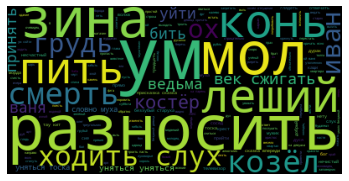

In [19]:
plt.imshow(wcloud) # создаем изображение
plt.axis("off") # выключаем оси для красоты
plt.show() # показываем график на экран

Можем добавить к списку стоп-слов еще несколько, ничего кроме стандартного `.extend()` нам не понадобится:

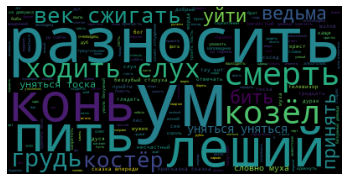

In [20]:
stop_ru.extend(["ох", "ваня", "зина", "иван", "мол", "ой", "нету"])

wcloud = WordCloud(stopwords = stop_ru).generate(text_norm)

plt.imshow(wcloud) # создаем изображение
plt.axis("off") # выключаем оси для красоты
plt.show() # показываем график на экран

Доработаем полученное облако, используя возможности `matplotlib`.

Функция `subplots()` создает два объекта:

* «рамка» для картинки (обычно сохраняется в переменную `fig`);
* поле с осями, внутри которого строится график (обычно сохраняется в переменную `ax`).

Неформально, создавая `fig` мы резервируем место под картинку соответствующего размера, а затем проводим различные манипуляции с `ax`, чтобы внутри этого поля для картинки построить график, настроить подписи, оси и прочее. Соответственно, к `ax` мы будем применять различные методы, а по завершении работы сможем выгрузить объект `fig` в файл PNG, JPEG или PDF. Вообще функция `subplots()`, как следует из её названия, может использоваться для построения сразу нескольких графиков, но у нас пока внутри `fig` будет один.

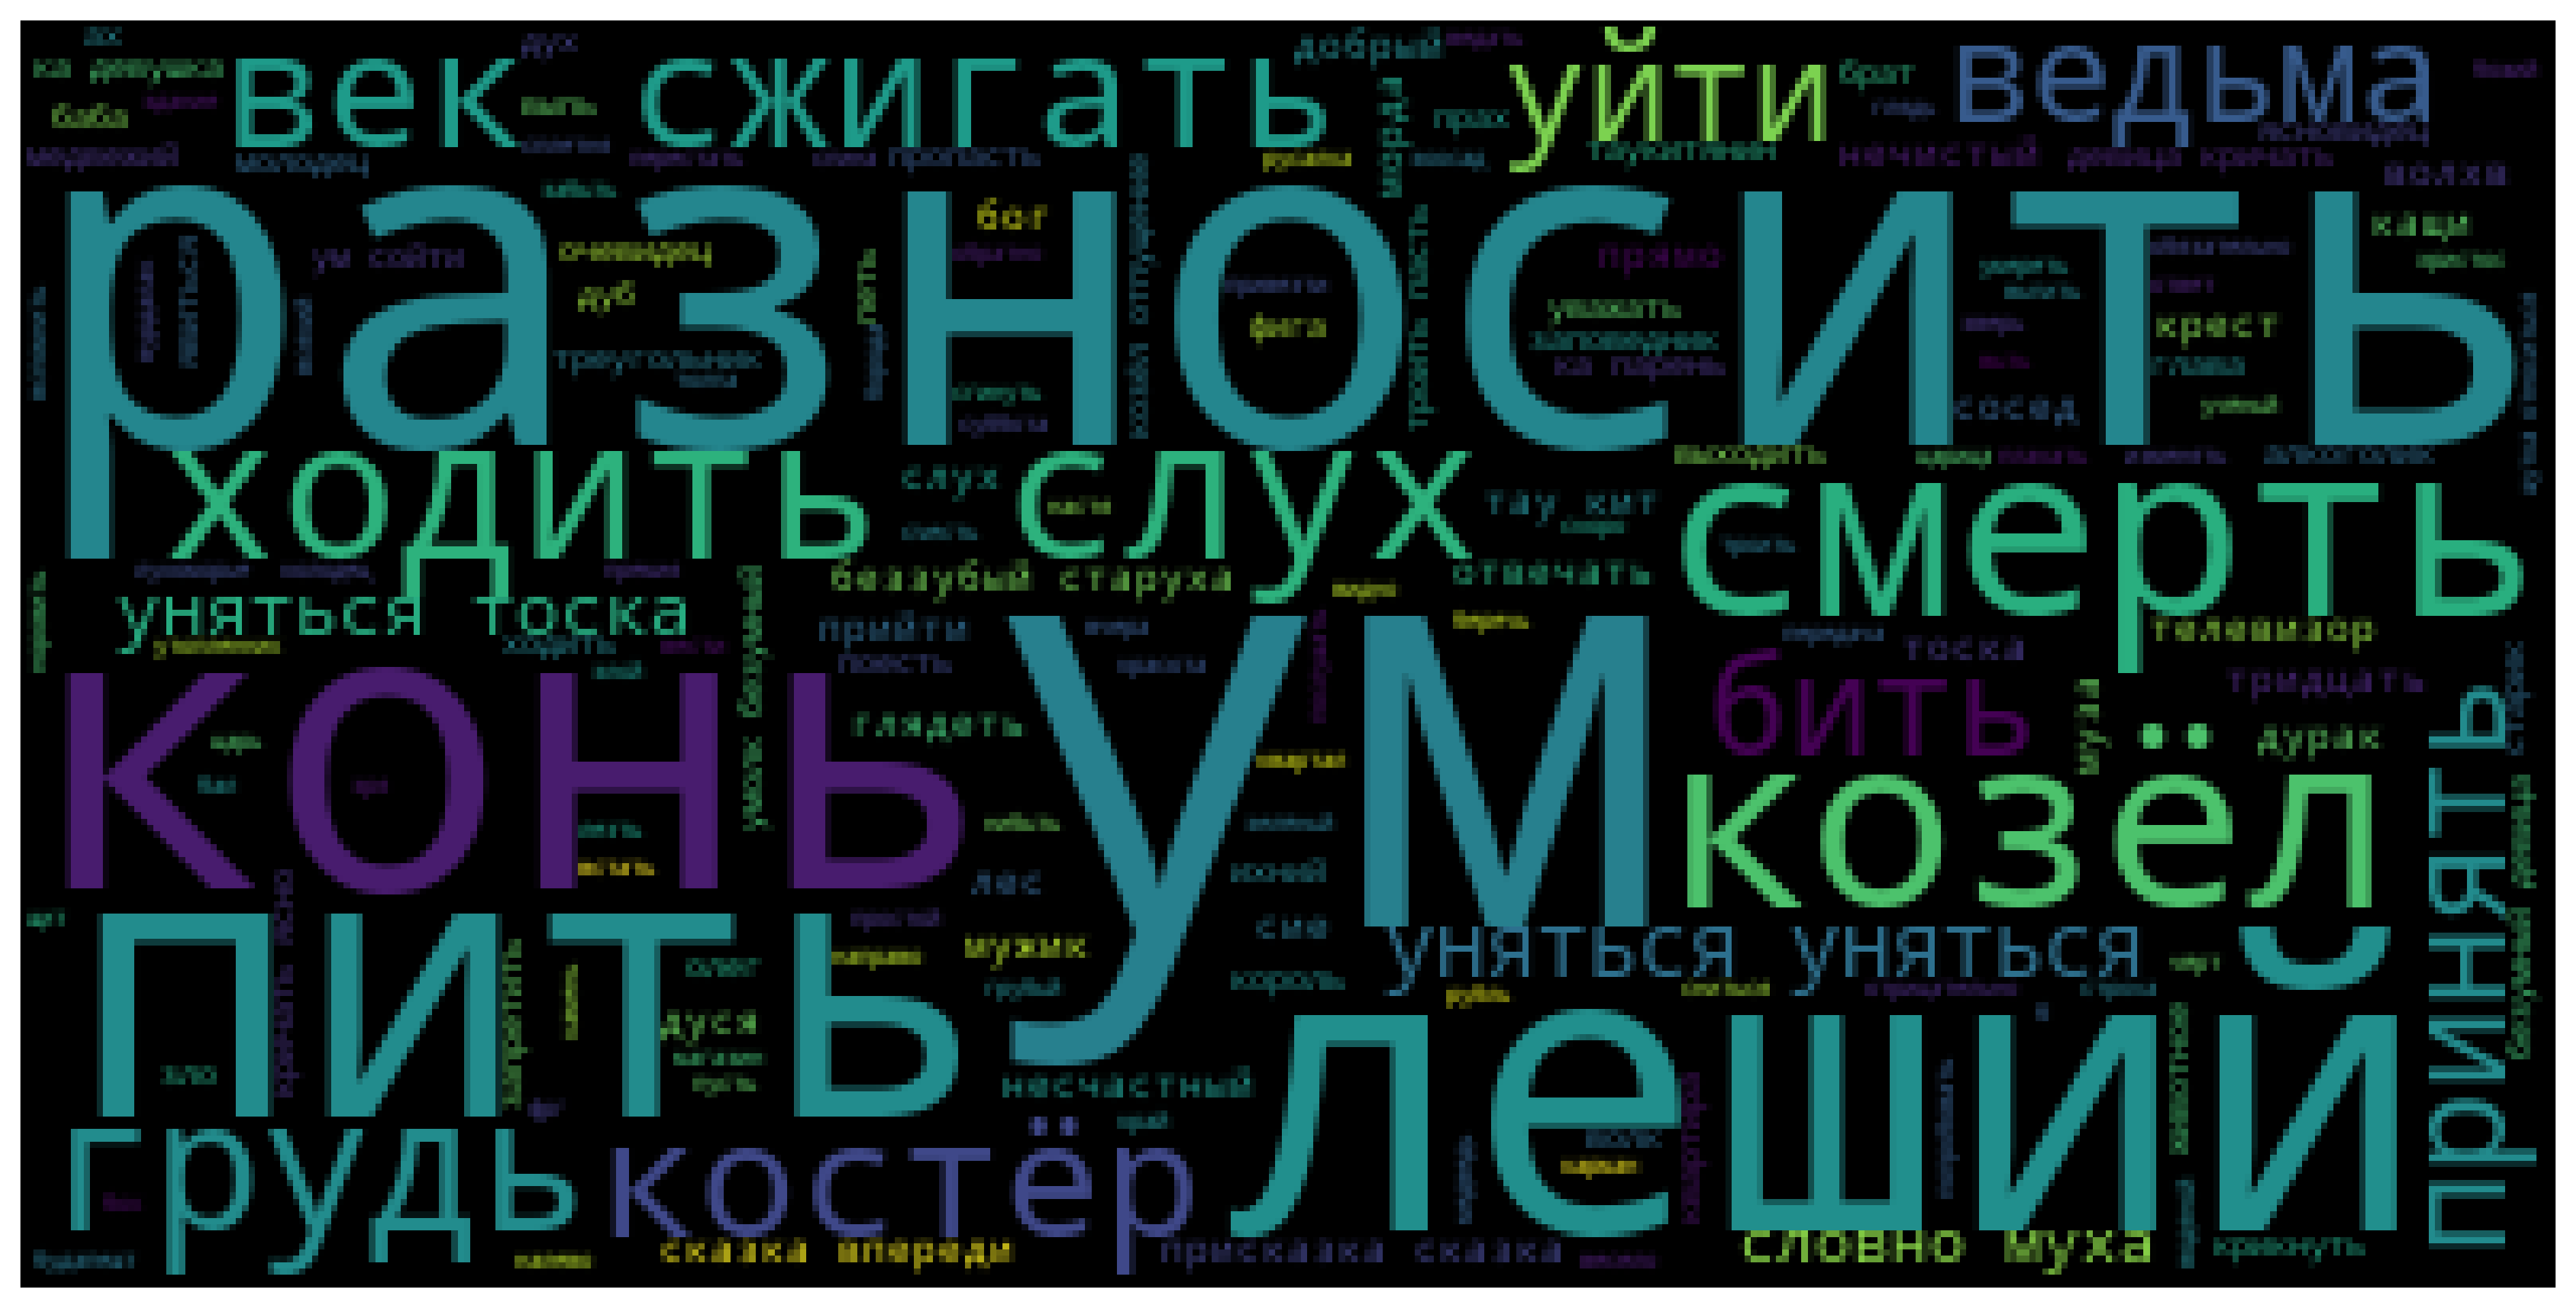

In [21]:
# figsize - размер в дюймах, делаем 16 на 9
# dpi, от dots per inch – разрешение 300 точек на дюйм (это хорошо даже для печати)

fig, ax = plt.subplots(figsize = (16, 9), dpi = 300);
ax.imshow(wcloud);
ax.axis("off");

**Дополнение.** Разрешение в итоге получилось не очень хорошим, нужно синхронизировать размер облака в `WordCloud()` и `subplots()`. В `WordCloud()` можно добавить ширину и высоту изображения с облаком (в пикселях), чтобы оно было побольше (по умолчанию 400 на 200):

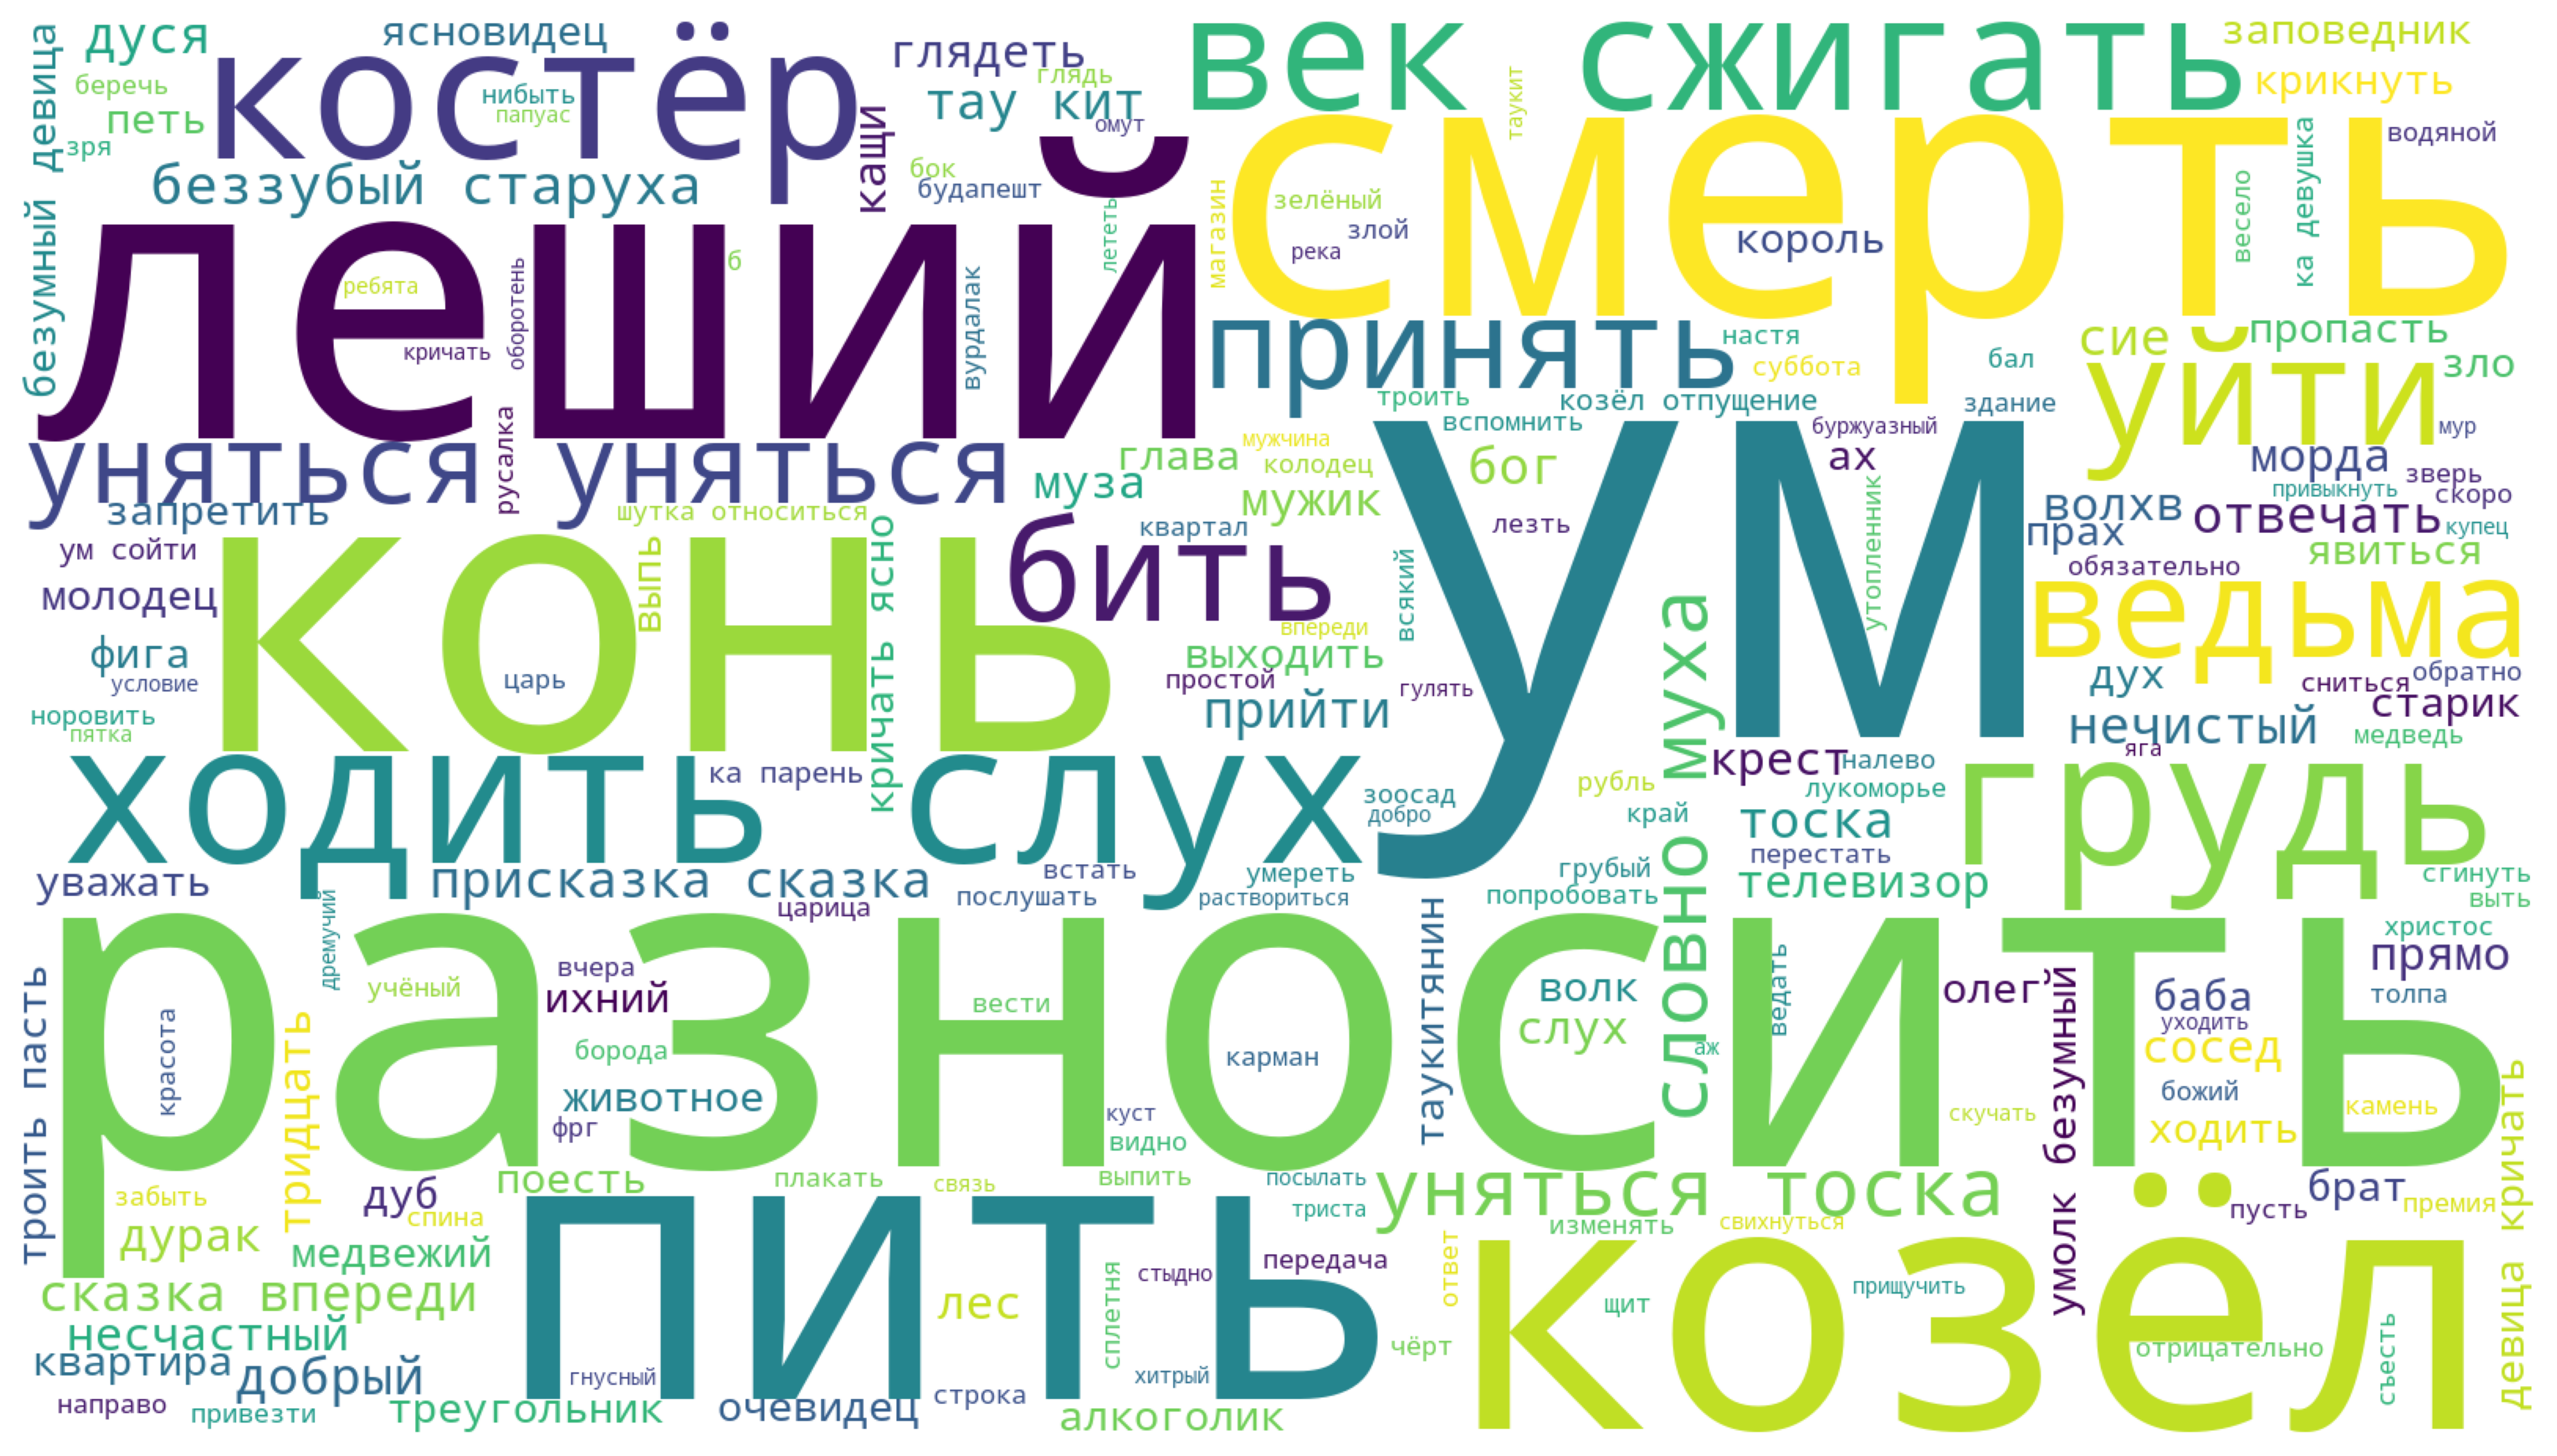

In [22]:
# width и height
# плюс, поменяем цвет фона в background_color

wcloud = WordCloud(stopwords = stop_ru, 
                  background_color = "white",
                  width = 1600,
                  height = 900).generate(text_norm)

fig, ax = plt.subplots(figsize = (16, 9), dpi = 300)
ax.imshow(wcloud)
ax.axis("off")

# можем сохранить картинку в файл png
# будет рядом с текущим ipynb

fig.savefig("wordcloud.png")

### Задача 4

Используя изображение из файла `guitar.jpeg`, добавьте маску для облака слов, чтобы сделать его в форме гитары.

В качестве основы для облака слов можно взять изображение, это прекрасно описано в тьюториале [здесь](https://www.datacamp.com/tutorial/wordcloud-python). Мы возьмём векторное изображение с [Freepik](https://ru.freepik.com/). Импортируем набор функций для обработки изображения из библиотеки `PIL` (*Python Imaging Library*) и библиотеку `numpy`, чтобы потом преобразовать изображение в числовой массив:

In [23]:
from PIL import Image
import numpy as np

In [24]:
# каждый пиксель в формате RGB (код цвета Reg-Green-Blue)

my_mask = np.array(Image.open("guitar.jpeg"))
print(my_mask)

[[[123 123 123]
  [123 123 123]
  [123 123 123]
  ...
  [123 123 123]
  [123 123 123]
  [123 123 123]]

 [[251 251 251]
  [251 251 251]
  [251 251 251]
  ...
  [251 251 251]
  [251 251 251]
  [251 251 251]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 33  33  33]
  [ 16  16  16]
  [  7   7   7]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0   0   0]
  [  0   0   0]
  [  2   2   2]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  2   2   2]
  [  0   0   0]
  [  0   0   0]]]


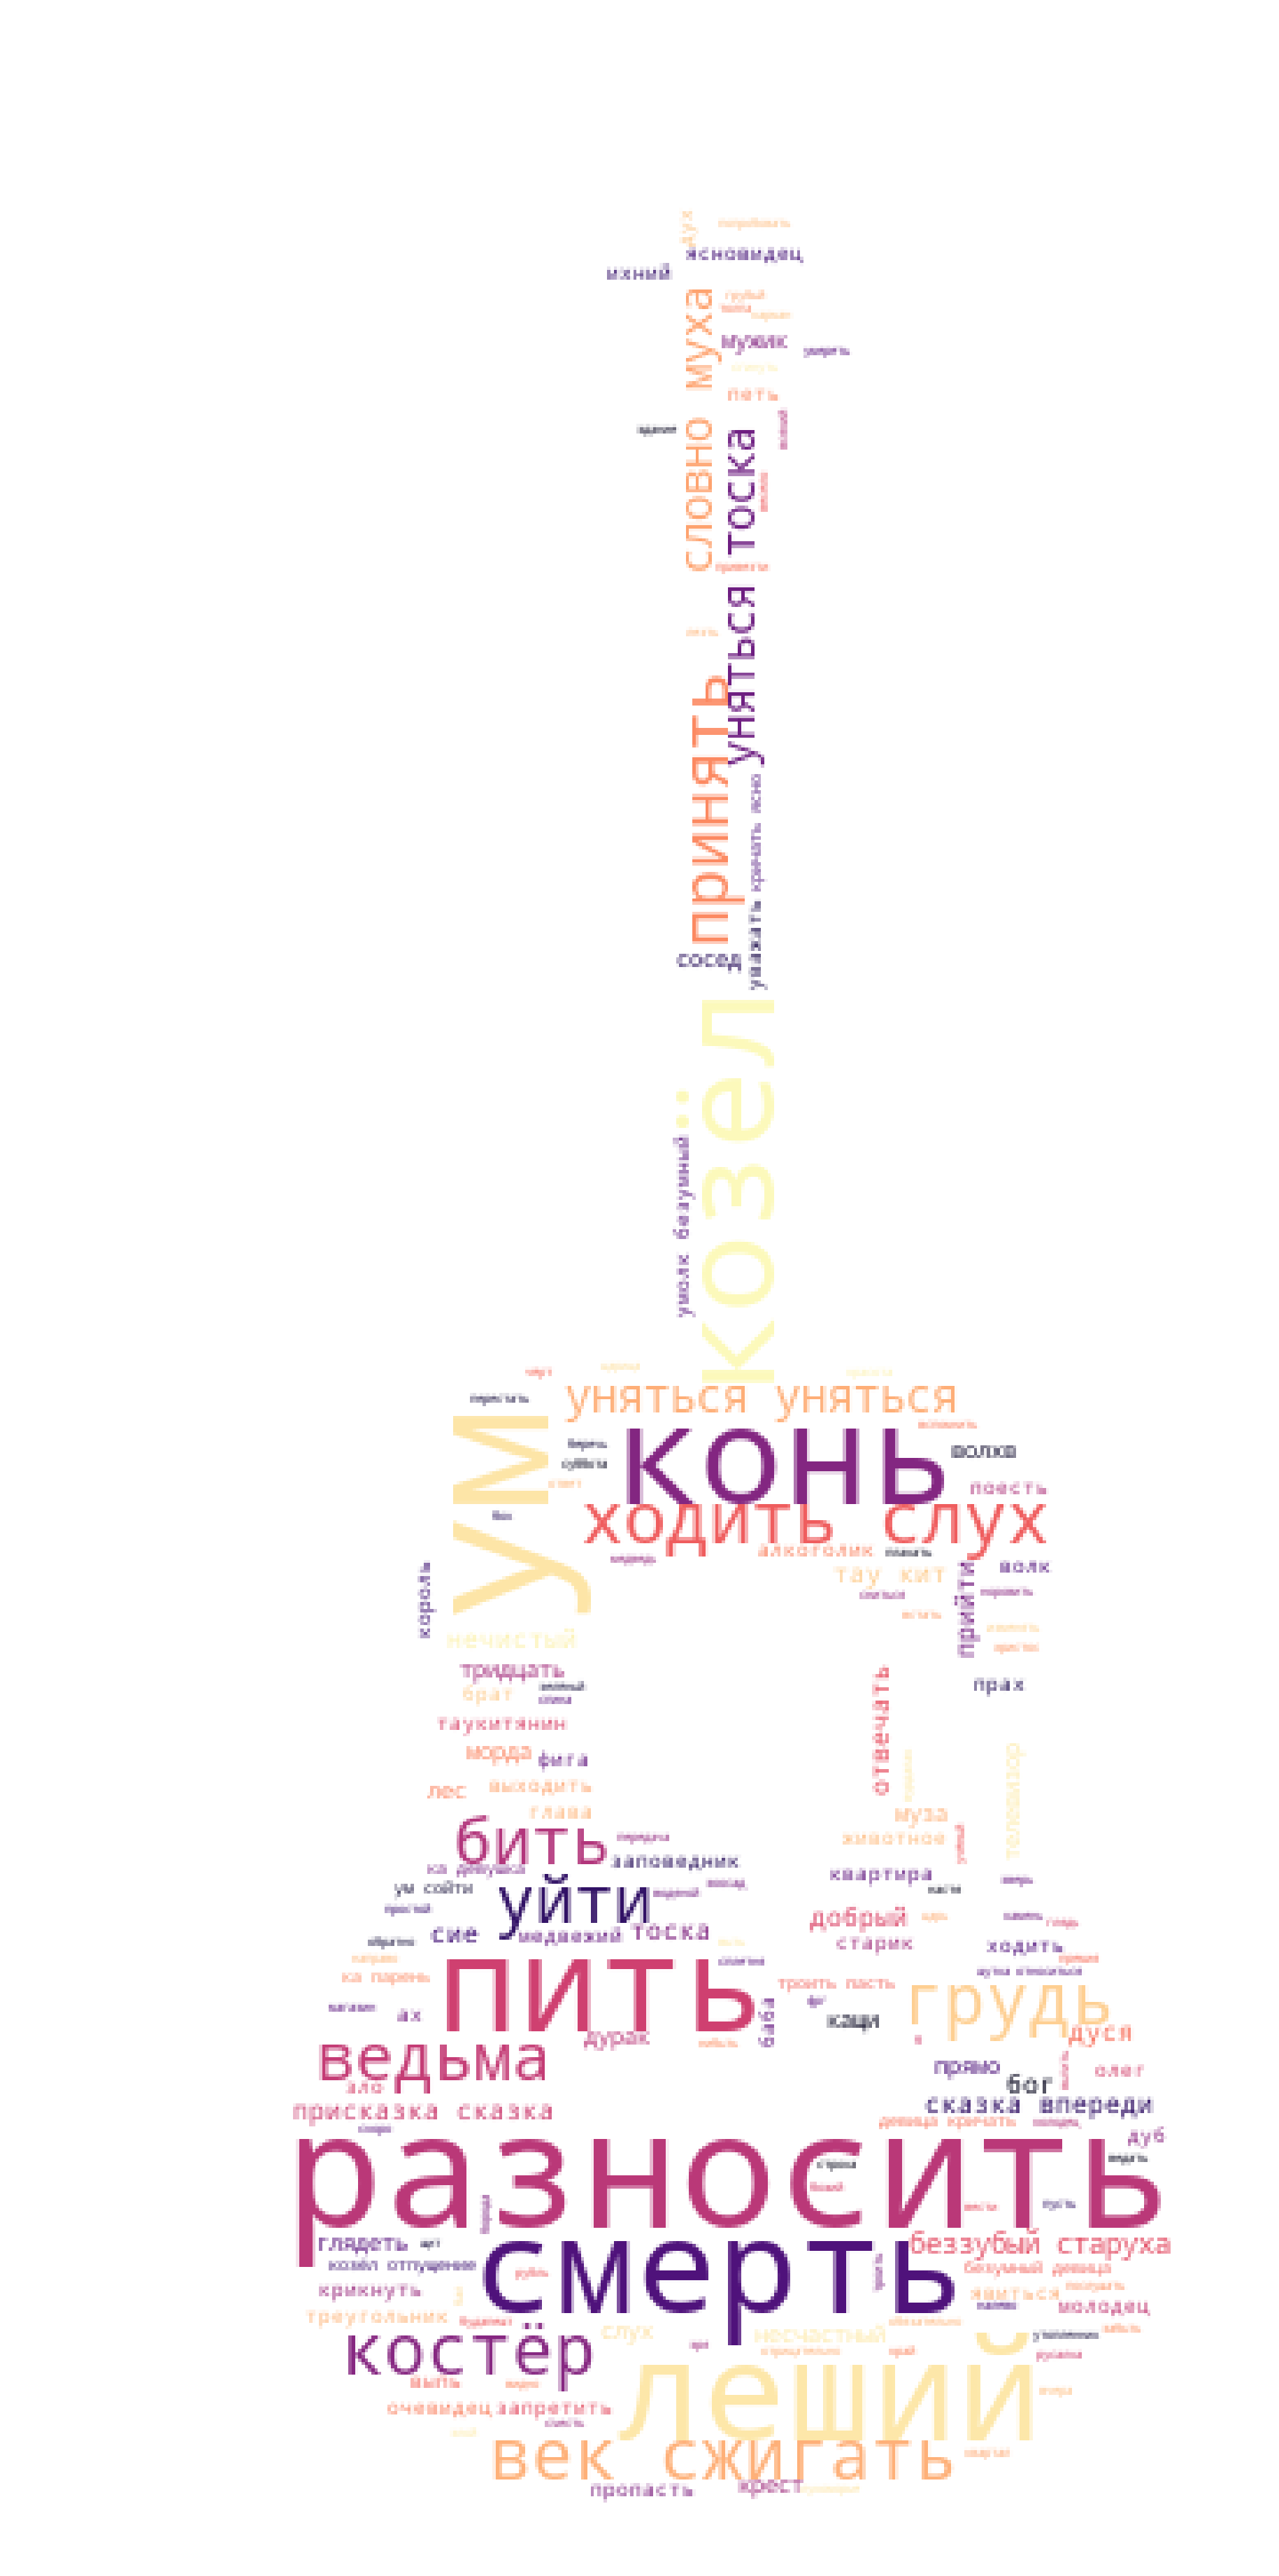

In [25]:
# добавляем маску в mask
# для примера меняем цветовую палитру colormap
# с размерами и разрешением надо отдельно поработать
# (вытянутый по вертикали файл)

wcloud = WordCloud(stopwords = stop_ru, 
                   background_color = "white",
                   mask = my_mask,
                   colormap = "magma").generate(text_norm)

fig, ax = plt.subplots(figsize = (9, 16), dpi = 300);
ax.imshow(wcloud);
ax.axis("off");

Про палитры в `matplotlib` можно почитать [здесь](https://matplotlib.org/stable/users/explain/colors/colormaps.html).